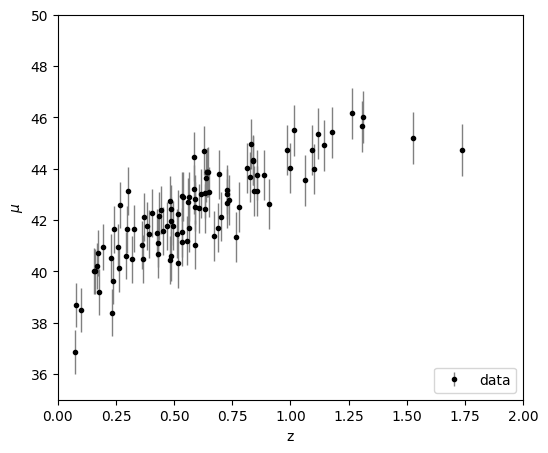

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')


[39.48384602  4.76438865]


/home/giacomo/myenv/lib/python3.12/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


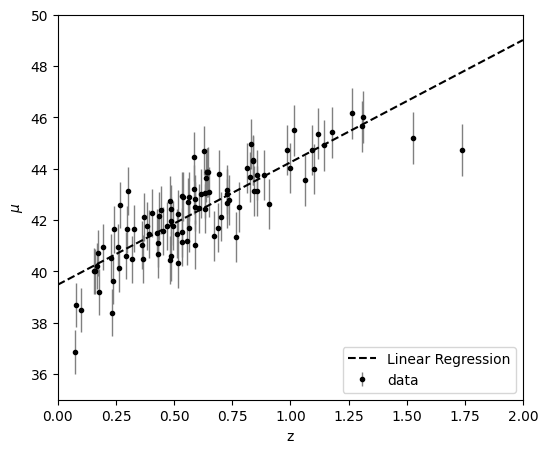

In [3]:
from astroML.linear_model import LinearRegression

model = LinearRegression()
model.fit(z_sample[:, np.newaxis], mu_sample, dmu)

print(model.coef_)
xgrid = np.linspace(0,2,1000)
ypred = model.predict(xgrid[:,np.newaxis])

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax.plot(xgrid,ypred,linestyle='--',color='black',label='Linear Regression')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')


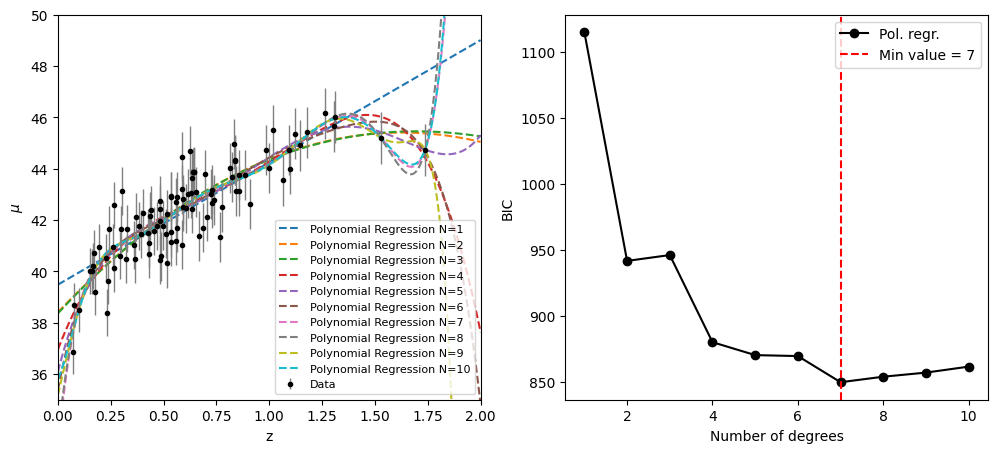

In [4]:
from astroML.linear_model import PolynomialRegression
bic=[]
fig,ax=plt.subplots(1,2,figsize=(12,5))
N=np.arange(1,11)

for degree in N:
    model = PolynomialRegression(degree)
    model.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    ypred = model.predict(xgrid[:,np.newaxis])
    mu_pred = model.predict(z_sample[:,np.newaxis])
    chi2 = np.sum(((mu_sample - mu_pred) / dmu) ** 2)
    k = len(model.coef_)
    bic.append(np.sqrt(len(mu_sample)) * chi2 + len(model.coef_) * np.log(len(mu_sample)))
    
    ax[0].plot(xgrid,ypred,linestyle='--',label='Polynomial Regression N={:d}'.format(degree))

ax[0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
ax[0].set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax[0].legend(loc='lower right',fontsize=8)

ax[1].plot(N,bic,linestyle='-',marker='o',color='black',label='Pol. regr.')
ax[1].axvline(N[np.argmin(bic)], linestyle='--',color='red',label='Min value = {:d}'.format(N[np.argmin(bic)]))
ax[1].set(xlabel='Number of degrees',ylabel='BIC')
ax[1].legend(loc='upper right')

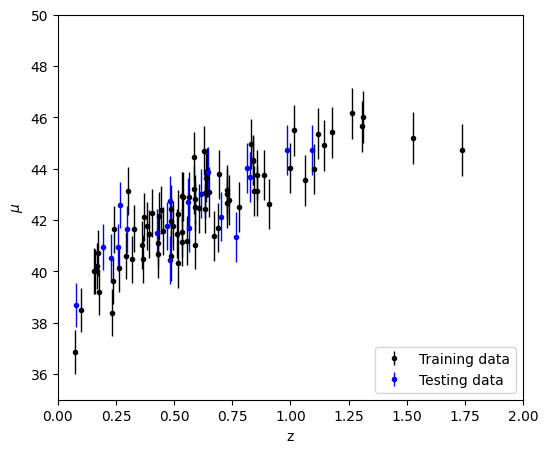

In [5]:
from sklearn.model_selection import train_test_split
# now let's divide the dataset into a training and a testing set ando redo the same
# this time we'll plot some more informations like the residual plot,
# useful in order to understand how far the datas are from the regression
z_train, z_val, mu_train, mu_val, dmu_train, dmu_val = train_test_split(
    z_sample, mu_sample, dmu, test_size=0.2, random_state=42
)

z_train = z_train[:, np.newaxis]
z_val = z_val[:, np.newaxis]

fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_val, mu_val, dmu_val, fmt='.b', lw=1, label='Testing data')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')

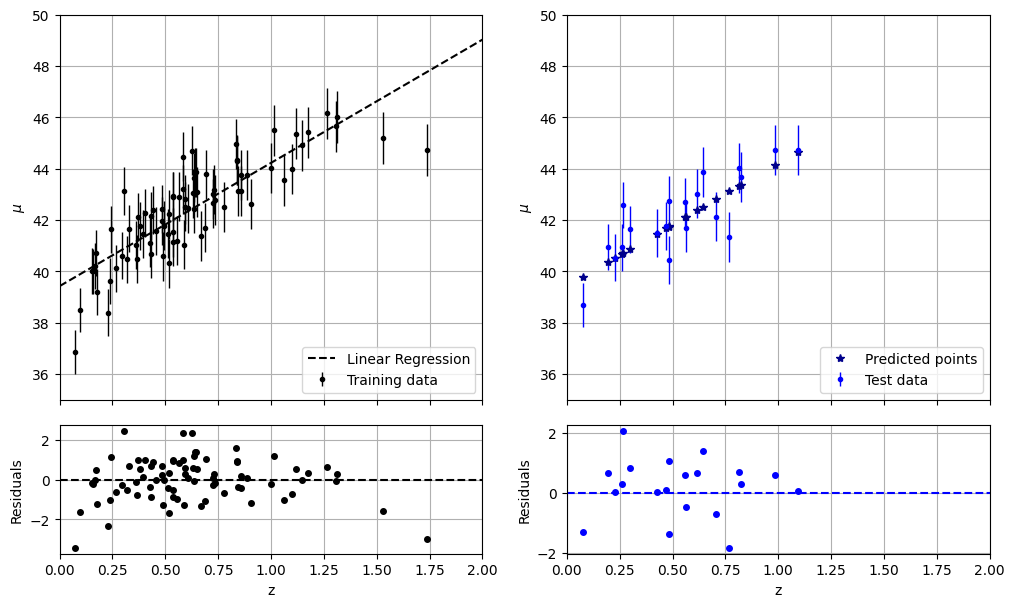

In [6]:
from matplotlib.gridspec import GridSpec

model = LinearRegression()
model.fit(z_train, mu_train, dmu_train)

mu_pred_val = model.predict(z_val)
mu_pred_train = model.predict(z_train)

# residuals
residuals_train = (mu_train - mu_pred_train) / dmu_train
residuals_val = (mu_val - mu_pred_val) / dmu_val

# layout setup
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 2, height_ratios=[3, 1], hspace=0.1)


# --- Left column for training data ---

ax0 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax0)

xgrid = np.linspace(0, 2, 1000)
ypred_grid = model.predict(xgrid[:, np.newaxis])

ax0.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax0.plot(xgrid, ypred_grid, linestyle='--', color='black', label='Linear Regression')
ax0.set(ylabel=r'$\mu$', xlim=(0, 2), ylim=(35, 50))
ax0.legend(loc='lower right')
ax0.grid(True)
plt.setp(ax0.get_xticklabels(), visible=False)

ax2.axhline(0, color='k', linestyle='--')
ax2.plot(z_train, residuals_train, 'ko', markersize=4)
ax2.set(xlabel='z', ylabel='Residuals')
ax2.grid(True)

# --- Right column for testing data ---
ax1 = fig.add_subplot(gs[0, 1])  # Dati validation
ax3 = fig.add_subplot(gs[1, 1], sharex=ax1)  # Residui validation

ax1.errorbar(z_val, mu_val, dmu_val, fmt='.b', lw=1, label='Test data')
ax1.plot(z_val, mu_pred_val, markersize=6, marker='*', color='darkblue', linestyle='', label='Predicted points')
ax1.set(ylabel=r'$\mu$', xlim=(0, 2), ylim=(35, 50))
ax1.legend(loc='lower right')
ax1.grid(True)
plt.setp(ax1.get_xticklabels(), visible=False)

ax3.axhline(0, color='blue', linestyle='--')
ax3.plot(z_val, residuals_val, 'bo', markersize=4)
ax3.set(xlabel='z', ylabel='Residuals')
ax3.grid(True)

plt.show()


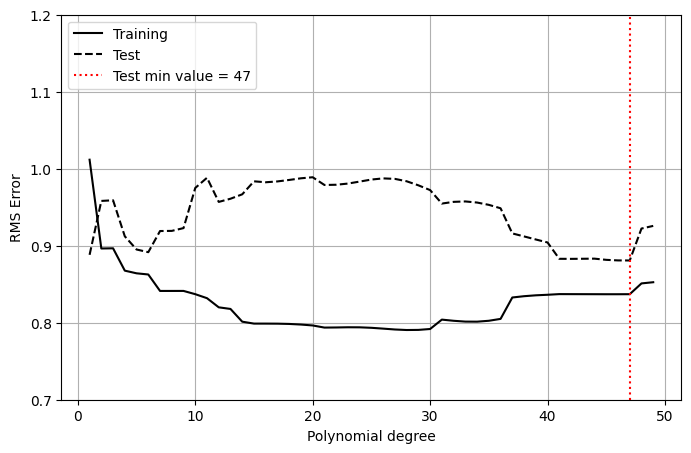

In [7]:
train_err=[]
val_err=[]
N=np.arange(1,50)
# this time instead of looking at the BIC,
# for choosing the best degree we look at the perform on the test dataset
# by looking at the RMS error

for degree in N:
    model = PolynomialRegression(degree)
    model.fit(z_train, mu_train, dmu_train)
    mu_pred_val = model.predict(z_val)
    mu_pred_train = model.predict(z_train)

    train_err.append(np.sqrt(np.sum((mu_pred_train-mu_train)**2)/len(z_train)))
    val_err.append(np.sqrt(np.sum((mu_pred_val-mu_val)**2)/len(z_val)))

minimum= N[np.argmin(val_err)]
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.plot(N,train_err, '-k', label='Training')
ax.plot(N,val_err, '--k', label='Test')
ax.axvline(minimum, linestyle=':', color='red',label = 'Test min value = {:d}'.format(minimum))
ax.set(xlabel='Polynomial degree',ylabel='RMS Error',ylim=(0.7,1.2))
ax.legend()
ax.grid(True)

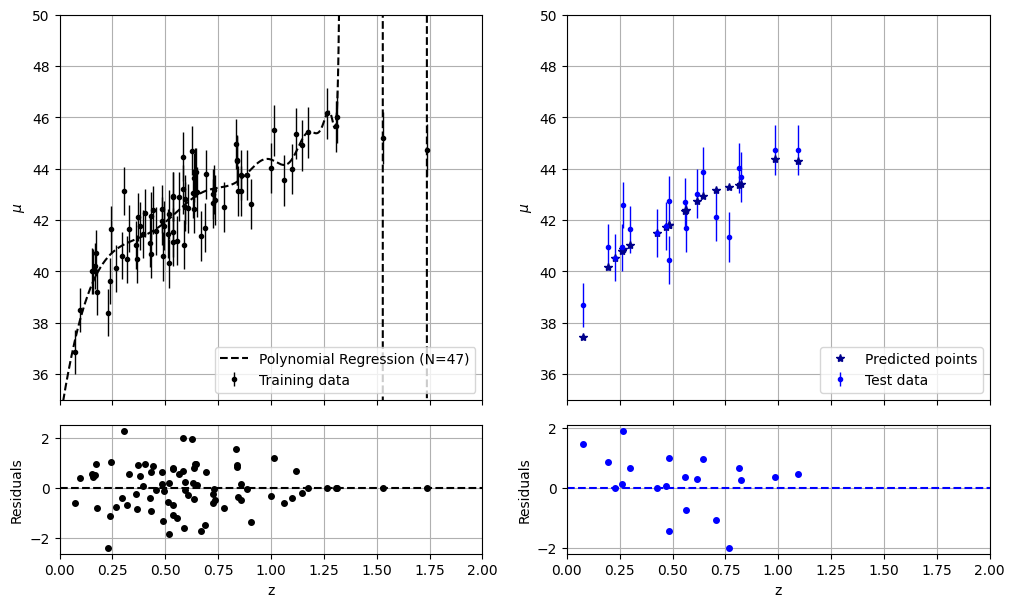

In [8]:

model = PolynomialRegression(minimum)
model.fit(z_train, mu_train, dmu_train)

mu_pred_val = model.predict(z_val)
mu_pred_train = model.predict(z_train)

# residuals
residuals_train = (mu_train - mu_pred_train) / dmu_train
residuals_val = (mu_val - mu_pred_val) / dmu_val

# layout setup
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 2, height_ratios=[3, 1], hspace=0.1)


# --- Left column for training data ---

ax0 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax0)

xgrid = np.linspace(0, 2, 1000)
ypred_grid = model.predict(xgrid[:, np.newaxis])

ax0.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax0.plot(xgrid, ypred_grid, linestyle='--', color='black', label=f'Polynomial Regression (N={minimum:d})')
ax0.set(ylabel=r'$\mu$', xlim=(0, 2), ylim=(35, 50))
ax0.legend(loc='lower right')
ax0.grid(True)
plt.setp(ax0.get_xticklabels(), visible=False)

ax2.axhline(0, color='k', linestyle='--')
ax2.plot(z_train, residuals_train, 'ko', markersize=4)
ax2.set(xlabel='z', ylabel='Residuals')
ax2.grid(True)

# --- Right column for testing data ---
ax1 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1], sharex=ax1)

ax1.errorbar(z_val, mu_val, dmu_val, fmt='.b', lw=1, label='Test data')
ax1.plot(z_val, mu_pred_val, markersize=6, marker='*', color='darkblue', linestyle='', label='Predicted points')
ax1.set(ylabel=r'$\mu$', xlim=(0, 2), ylim=(35, 50))
ax1.legend(loc='lower right')
ax1.grid(True)
plt.setp(ax1.get_xticklabels(), visible=False)

ax3.axhline(0, color='blue', linestyle='--')
ax3.plot(z_val, residuals_val, 'bo', markersize=4)
ax3.set(xlabel='z', ylabel='Residuals')
ax3.grid(True)

plt.show()


/home/giacomo/myenv/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1471: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


Score on the test dataset: -0.8439666392777937


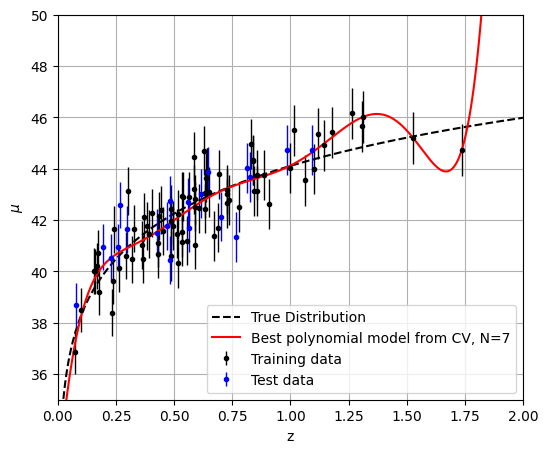

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from astropy.cosmology import LambdaCDM

# let's actually use Cross Validation to see if our naive prediction on the polynomial degree from before is valid

fig,ax=plt.subplots(1,1,figsize=(6,5))
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
mu_true = cosmo.distmod(xgrid)
ax.plot(xgrid, mu_true, linestyle='--', marker='', color='black', label='True Distribution')
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_val, mu_val, dmu_val, fmt='.b', lw=1, label='Test data')

scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Polynomial Regression Cross Validation
param_grid = {'degree': np.arange(1, 50)}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=scorer)
grid.fit(z_train, mu_train)
best_poly = grid.best_estimator_
mu_fit = best_poly.predict(xgrid[:, np.newaxis])
print(f'Score on the test dataset: {grid.score(z_val,y=mu_val)}')
ax.plot(xgrid, mu_fit, '-r', label=f'Best polynomial model from CV, N={grid.best_params_["degree"]}')


ax.set(xlabel='z', ylabel=r'$\mu$', xlim=(0,2), ylim=(35,50))
ax.legend(loc='lower right')
ax.grid(True)

/home/giacomo/myenv/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1471: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


Score on the test dataset: -1.1962622474284441


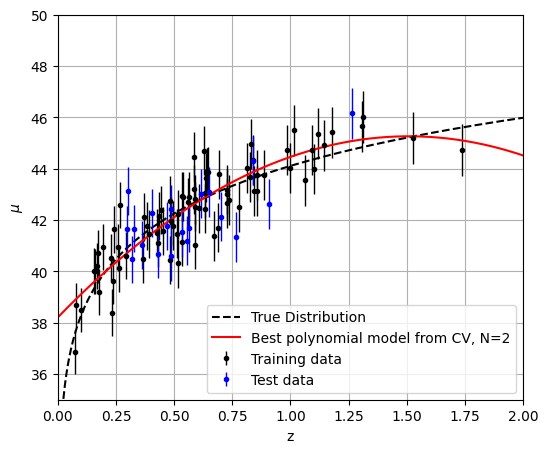

In [10]:
# note that the performance of our model in this case depends a lot on how you split the data

z_train, z_val, mu_train, mu_val, dmu_train, dmu_val = train_test_split(
    z_sample, mu_sample, dmu, test_size=0.2, random_state=20    # using a different random_state
)

z_train = z_train[:, np.newaxis]
z_val = z_val[:, np.newaxis]

fig,ax=plt.subplots(1,1,figsize=(6,5))
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
mu_true = cosmo.distmod(xgrid)
ax.plot(xgrid, mu_true, linestyle='--', marker='', color='black', label='True Distribution')
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_val, mu_val, dmu_val, fmt='.b', lw=1, label='Test data')

scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Polynomial Regression Cross Validation
param_grid = {'degree': np.arange(1, 50)}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=scorer)
grid.fit(z_train, mu_train)
best_poly = grid.best_estimator_
mu_fit = best_poly.predict(xgrid[:, np.newaxis])
print(f'Score on the test dataset: {grid.score(z_val,y=mu_val)}')
ax.plot(xgrid, mu_fit, '-r', label=f'Best polynomial model from CV, N={grid.best_params_["degree"]}')


ax.set(xlabel='z', ylabel=r'$\mu$', xlim=(0,2), ylim=(35,50))
ax.legend(loc='lower right')
ax.grid(True)

Score on the test dataset: -1.0748801033700988


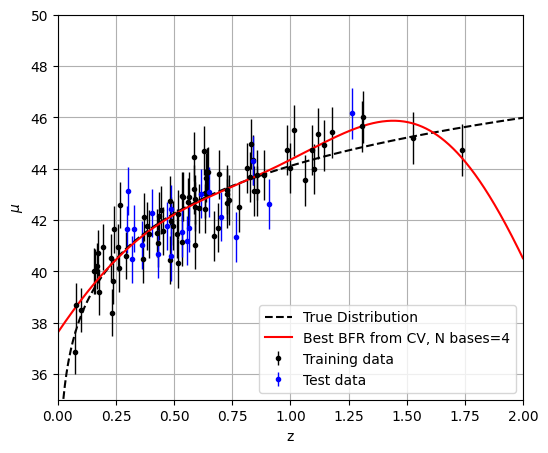

In [11]:
from astroML.linear_model import BasisFunctionRegression
from sklearn.base import BaseEstimator, RegressorMixin

# let's try CV using other linear models,
# since we are using astroML models, we need to define a class
# in order to make it work with GridSearchCV

class BFRModel(BaseEstimator, RegressorMixin):
    def __init__(self, n_bases=10):
        self.n_bases = n_bases

    def fit(self, X, y):
        X = np.asarray(X).ravel()
        self.basis_mu = np.linspace(X.min(), X.max(), self.n_bases)[:, None]
        self.basis_sigma = 1.0 * (self.basis_mu[1] - self.basis_mu[0])
        self.model = BasisFunctionRegression('gaussian', mu=self.basis_mu, sigma=self.basis_sigma)
        self.model.fit(X[:, None], y)
        return self

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 2:
            X = X.ravel()
        return self.model.predict(X[:, None])

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_val, mu_val, dmu_val, fmt='.b', lw=1, label='Test data')
ax.plot(xgrid, mu_true, linestyle='--', marker='', color='black', label='True Distribution')

param_grid = {'n_bases': np.arange(3, 21)}

grid = GridSearchCV(
    BFRModel(), param_grid,
    cv=10,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

grid.fit(z_train, mu_train)
mu_fit = grid.predict(xgrid[:, np.newaxis])
print(f'Score on the test dataset: {grid.score(z_val,y=mu_val)}')
ax.plot(xgrid, mu_fit, '-r', label=f'Best BFR from CV, N bases={grid.best_params_['n_bases']}')

ax.set(xlabel='z', ylabel=r'$\mu$', xlim=(0,2), ylim=(35,50))
ax.legend(loc='lower right')
ax.grid(True)


Score on the test dataset: -0.9121285555941618


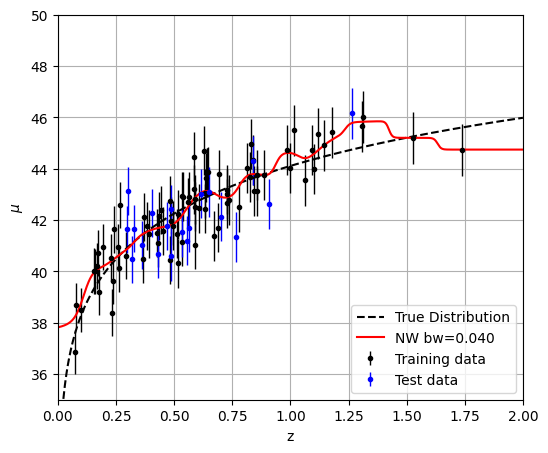

In [12]:
from astroML.linear_model import NadarayaWatson

# let's do the same as before but with NW

class NWModel(BaseEstimator, RegressorMixin):
    def __init__(self, bandwidth=0.1, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 2:
            X = X.ravel()
        self.model = NadarayaWatson(kernel=self.kernel, h=self.bandwidth)
        self.model.fit(X[:, None], y)
        return self

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 2:
            X = X.ravel()
        return self.model.predict(X[:, None])

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_val, mu_val, dmu_val, fmt='.b', lw=1, label='Test data')
ax.plot(xgrid, mu_true, linestyle='--', marker='', color='black', label='True Distribution')

param_grid = {'bandwidth': np.linspace(0.01, 0.2, 20)}

grid = GridSearchCV(
    NWModel(kernel='gaussian'),
    param_grid,
    cv=10,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

grid.fit(z_train, mu_train)
mu_pred = grid.predict(xgrid[:, np.newaxis])
print(f'Score on the test dataset: {grid.score(z_val,y=mu_val)}')
ax.plot(xgrid, mu_pred, '-r', label=f'NW bw={grid.best_params_["bandwidth"]:.3f}')

ax.set(xlabel='z', ylabel=r'$\mu$', xlim=(0,2), ylim=(35,50))
ax.legend(loc='lower right')
ax.grid(True)